In [11]:
import os
import dask.bag as db
import dask.dataframe as dd
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS

# Load NLTK stopwords
#nltk.download('stopwords')
from nltk.corpus import stopwords


#nltk.download('stopwords')
LIMIT = 10000

# Get a list of all txt files in the 'text_files' folder
text_files = [os.path.join("text_files", f) for f in os.listdir("text_files")[:LIMIT] if f.endswith(".txt")]

# Define a function to process each text file
def process_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

# Create a Dask bag from the text files
file_bag = db.from_sequence(text_files).map(process_file)

# Convert the Dask bag to a Pandas DataFrame
df = file_bag.to_dataframe(columns=['content']).compute()

In [12]:
print(f"Shape: {df.shape}\n\nHead: {df.head()}\n\nFirst Entry: {df.iloc[0].content}")

Shape: (10000, 1)

Head:                                              content
0  arXiv:astro-ph/0512311v1  13 Dec 2005\nREVISED...
1  arXiv:0711.4572v1  [astro-ph]  28 Nov 2007\nMo...
2  arXiv:0811.3813v1  [cond-mat.supr-con]  24 Nov...
3  arXiv:cond-mat/0108247v2  [cond-mat.dis-nn]  3...
4  arXiv:hep-ph/0304019v2  3 Apr 2003\nCERN-TH/20...

First Entry: arXiv:astro-ph/0512311v1  13 Dec 2005
REVISED VERSION DECEMBER 12, 2005. Preprint typeset using LATEXstyle
Nonaxisymmetric Magnetorotational Instability in Proto-Neutron Stars
Youhei Masada1,2, Takayoshi Sano3, and Hideaki Takabe3
ABSTRACT
We investigate the stability of diﬀerentially rotating proto-neutron stars (PNSs) with a
toroidal magnetic ﬁeld. Stability criteria for nonaxisymmetric MHD instabilities are derived us-
ing a local linear analysis. PNSs are expected to have much stronger radial shear in the rotation
velocity compared to normal stars. We ﬁnd that nonaxisymmetric magnetorotational instability
(NMRI) with a large azimut

In [13]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.content)

def extract_top_n_keywords(X, feature_names, n=3):
    top_n_keywords = [
        [feature_names[i] for i in X[document_index].toarray().argsort()[0, -n:][::-1]]
        for document_index in range(X.shape[0])
    ]
    return top_n_keywords


top_n_keywords_per_document = extract_top_n_keywords(X, tfidf.get_feature_names_out(), n=10)
for i, keywords in enumerate(top_n_keywords_per_document[:5]):
    print(f"Document {i + 1}: {', '.join(keywords)}")

Document 1: the, nmri, pnss, of, growth, brunt, ais, kink, is, and
Document 2: the, jet, cp, helical, of, gabuzda, agn, in, pitch, polarization
Document 3: the, isotope, of, phonon, harmonic, ωp, and, eliashberg, fulleride, substitution
Document 4: the, of, ρl, ˆha, σaτ, σa, blocked, replica, in, conﬁgurations
Document 5: the, in, µi, of, mev, and, tricritical, is, we, chemical


In [15]:
def preprocess_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

print(preprocess_text(df.iloc[0].content))

arXiv astro ph 0512311v1 13 Dec 2005 REVISED VERSION DECEMBER 12 2005 Preprint typeset using LATEXstyle Nonaxisymmetric Magnetorotational Instability in Proto Neutron Stars Youhei Masada1 2 Takayoshi Sano3 and Hideaki Takabe3 ABSTRACT We investigate the stability of diﬀerentially rotating proto neutron stars PNSs with a toroidal magnetic ﬁeld Stability criteria for nonaxisymmetric MHD instabilities are derived us ing a local linear analysis PNSs are expected to have much stronger radial shear in the rotation velocity compared to normal stars We ﬁnd that nonaxisymmetric magnetorotational instability NMRI with a large azimuthal wavenumber m is dominant over the kink mode m 1 in dif ferentially rotating PNSs The growth rate of the NMRI is of the order of the angular velocity Ω which is faster than that of the kink type instability by several orders of magnitude The stability criteria are analogous to those of the axisymmetric magnetorotational instability with a poloidal ﬁeld although the

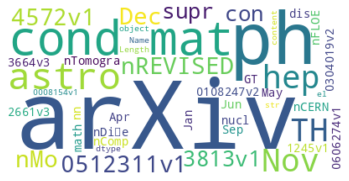

In [14]:
# Convert NLTK stopwords to a set
stopwords_set = set(stopwords.words("english"))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords_set, background_color="white")
wordcloud.generate(preprocess_text(str(df.content)))

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()